In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import models, training, distributions
# jax on M1: https://github.com/google/jax/issues/5501

/Users/martinmarek/miniforge3/envs/py39/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [3]:
%load_ext autoreload
%autoreload 2

## generate synthetic regression data

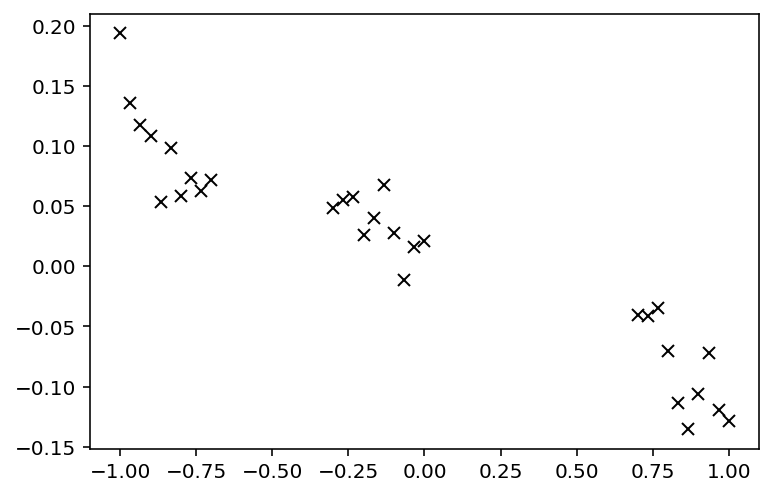

In [4]:
# observed x
x_train = jnp.concatenate([jnp.linspace(s, s+0.3, 10) for s in [-1, -0.3, 0.7]])
x_train = x_train[:, None]
N, C = x_train.shape

# true model
sigma_obs = 0.03
key = jax.random.PRNGKey(0)
w = 0.5 * jax.random.normal(key, [C])
y_train = jnp.dot(x_train, w) + jnp.power(0.2 * x_train[:, 1], 2.0) * jnp.sin(4.0 * x_train[:, 1])

# add noise
_, key = jax.random.split(key)
y_train += sigma_obs * jax.random.normal(key, [N])

# plot dataset
plt.plot(x_train[:, 0], y_train, 'kx')
plt.show()

## define model

In [5]:
# define model
# - when using a large NN with a small dataset, the prior must be very flat so that it doesn't dominate the likelihood
predict_fn, params_init = models.make_nn(x_train, 3*[100])
log_likelihood_fn = distributions.make_gaussian_log_likelihood(x_train, y_train, predict_fn)
log_prior_fn = distributions.make_gaussian_log_prior(10)
log_posterior_fn = distributions.make_log_posterior(log_likelihood_fn, log_prior_fn)

In [6]:
# TEST: NN params shape
print(jax.tree_map(lambda x: x.shape, params_init))

# TEST: prior, likelihood, posterior
print(log_prior_fn(params_init), log_likelihood_fn(params_init), log_posterior_fn(params_init))

FlatMap({
  'linear': FlatMap({'b': (100,), 'w': (1, 100)}),
  'linear_1': FlatMap({'b': (100,), 'w': (100, 100)}),
  'linear_2': FlatMap({'b': (100,), 'w': (100, 100)}),
  'linear_3': FlatMap({'b': (2,), 'w': (100, 2)}),
})
-66370.97 -21.006723 -66391.98


## RWMH

In [15]:
%%time
key = jax.random.PRNGKey(0)
n_steps = 10
n_blind_steps = 10_000
step_size = 1e-2
params_rwmh, log_prob_rwmh = training.rwmh_sampler(params_init, log_posterior_fn, key, n_steps, n_blind_steps, step_size)

CPU times: user 55.6 s, sys: 24.7 s, total: 1min 20s
Wall time: 34.7 s


In [8]:
# TODO: compute acceptance rate
# x_rwmh[-1]['linear']['w']
# jax.tree_multimap(lambda a, b: a==b, params_rwmh[:-1], params_rwmh[1:])

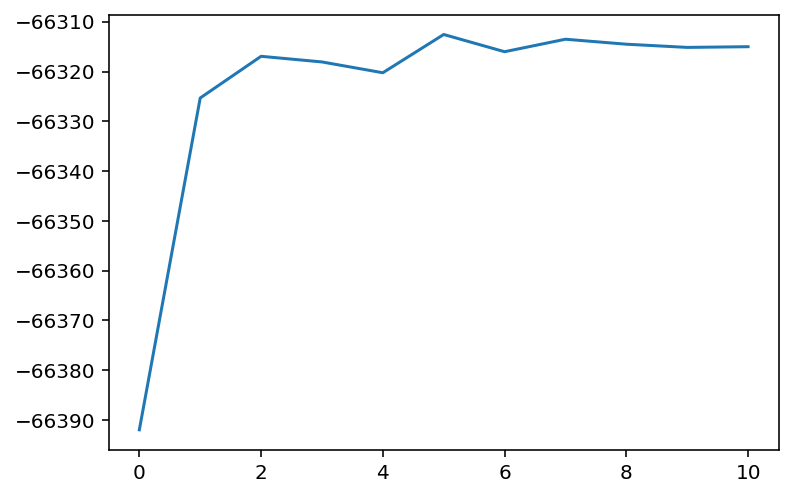

In [16]:
plt.plot(log_prob_rwmh)
plt.show()

## HMC

In [10]:
%%time
n_steps = 10
posterior_std = 0.1
step_size = 1e-4
trajectory_len = float(jnp.pi) / 2 * posterior_std
n_leapfrog_steps = int(trajectory_len // step_size + 1)
key = jax.random.PRNGKey(0)
print(f'{trajectory_len=:.3f}, {n_leapfrog_steps=:.0f}')
params_hmc, log_prob_hmc = training.hmc_sampler(params_init, log_posterior_fn, n_steps, n_leapfrog_steps, step_size, key)

trajectory_len=0.157, n_leapfrog_steps=1571
0.9503343
1.0
0.8816271
0.57625794
1.0
1.0
1.0
0.00032462564
1.0
0.0
CPU times: user 10.5 s, sys: 137 ms, total: 10.7 s
Wall time: 10.4 s


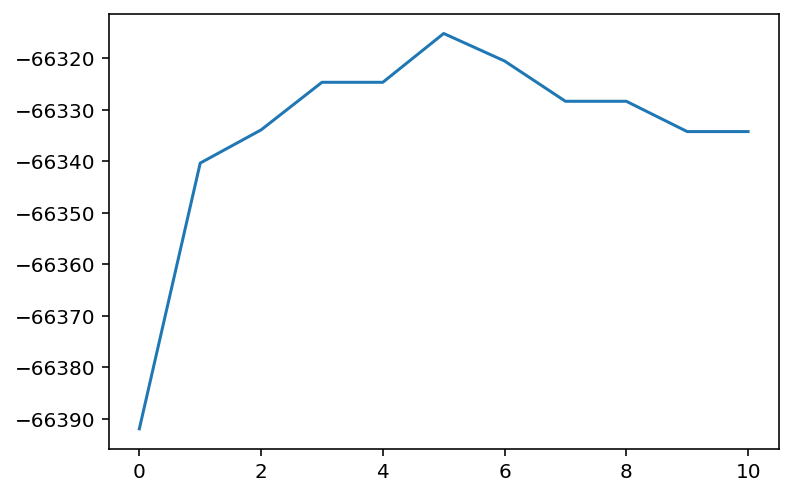

In [11]:
plt.plot(log_prob_hmc)
plt.show()

## SGD

In [12]:
%%time
# TODO: deep ensambles
params_sgd, log_prob_sgd = training.train_sgd(params_init, log_likelihood_fn, n_epochs=20_000, lr=1e-5, m=0)

CPU times: user 2.41 s, sys: 35.2 ms, total: 2.45 s
Wall time: 2.15 s


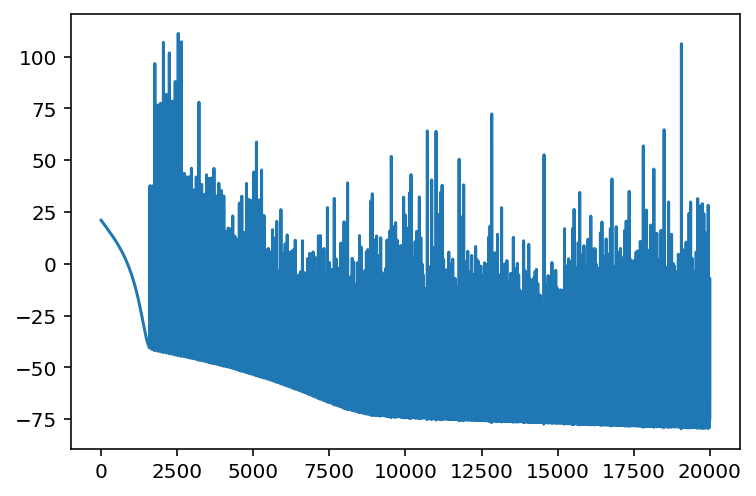

In [13]:
plt.plot(log_prob_sgd)

## plot predictions

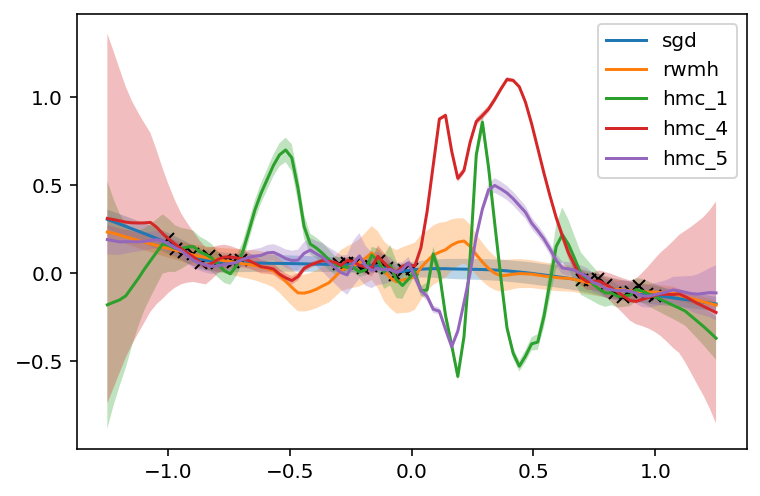

In [17]:
fig, ax = plt.subplots()

# plot training data
ax.plot(x_train[:, 0], y_train, 'kx')


# labeled results
labeled_params = {
    'sgd': params_sgd,
    'rwmh': params_rwmh[-1],
    'hmc_1': params_hmc[-1],
    'hmc_4': params_hmc[-5],
    'hmc_5': params_hmc[-6],
}

# plot predictions
x_full = jnp.linspace(-1.25, 1.25, 100)[:, None]
for label, params in labeled_params.items():
    y_hat = predict_fn(x_full, params)
    ax.fill_between(x_full[:, 0], y_hat[:, 0]-2*y_hat[:, 1], y_hat[:, 0]+2*y_hat[:, 1], alpha=0.3)
    ax.plot(x_full[:, 0], y_hat[:, 0], label=label)

ax.legend(loc='upper right')
plt.show()